In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [3]:
cardio = pd.read_csv('coris.csv')
pd.set_option('display.max_columns', None)

In [4]:
cardio.columns

Index(['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea',
       'obesity', 'alcohol', 'age', 'chd'],
      dtype='object')

In [5]:
cardio.drop('row.names', axis = 1, inplace = True)

In [6]:
cardio['famhist'] = cardio['famhist'].map({
    'Absent': 0, 'Present': 1
})

In [7]:
cardio['chd'].value_counts(normalize = True)

0    0.65368
1    0.34632
Name: chd, dtype: float64

In [8]:
# stratified test train split based on family history/ age strata

age_strata = cardio['age'] // 16
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(cardio, age_strata):
# for train_index, test_index in split.split(cardio, cardio['chd']):
    strat_train_set = cardio.iloc[train_index] 
    strat_test_set = cardio.iloc[test_index]

In [9]:
cardio = strat_train_set.copy()

In [10]:
corr_matrix = cardio.corr()
corr_matrix['chd'].sort_values(ascending = False)

chd          1.000000
age          0.375376
tobacco      0.309451
famhist      0.277175
ldl          0.255865
adiposity    0.246497
sbp          0.125386
typea        0.094392
obesity      0.081873
alcohol      0.039519
Name: chd, dtype: float64

In [11]:
labels = cardio['chd']
cardio.drop('chd', axis = 1, inplace = True)

In [12]:
num_attributes = ['age', 'tobacco', 'ldl', 'adiposity', 'sbp', 'alcohol', 'typea', 'obesity']
cat_attributes = ['famhist']

In [13]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [14]:
def exclude_obesity(X, exclude = False):
    if exclude == True:
        X.drop('obesity', axis = 1, inplace = True)
    return X

In [15]:
def exclude_alcohol(X, exclude = False):
    if exclude == True:
        X.drop('alcohol', axis = 1, inplace = True)
    return X

In [16]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('exclude_obesity', FunctionTransformer(exclude_obesity, validate = False, 
                                           kw_args = {"exclude": False})),
    ('exclude_alcohol', FunctionTransformer(exclude_alcohol, validate = False,
                                           kw_args = {"exclude": False})),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', MinMaxScaler(feature_range = (0, 100)))
])

cardio_num_tr = pd.DataFrame(num_pipeline.fit_transform(cardio))

In [17]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attributes))
])

data_prep_pipeline = FeatureUnion(transformer_list=[
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)])

In [18]:
cardio_prepared = pd.DataFrame(data_prep_pipeline.fit_transform(cardio))

### ML - model building


In [50]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.neural_network import MLPClassifier

In [108]:
def get_scores(y_true, y_pred):
    
    def get_precision_score(y_true, y_pred):
        return round(precision_score(y_true, y_pred), 2)
    
    def get_recall_score(y_true, y_pred):
        return round(recall_score(y_true, y_pred), 2)
    
    def get_fbeta_score(y_true, y_pred):
        return round(fbeta_score(y_true, y_pred, beta = 2), 2)
    
    print(f'precision   : {get_precision_score(y_true, y_pred)}')
    print(f'recall      : {get_recall_score(y_true, y_pred)}')
    print(f'fbeta score : {get_fbeta_score(y_true, y_pred)}')

In [52]:
fbeta_scorer = make_scorer(fbeta_score, beta = 1.2)

def get_fbeta_score(y_true, y_pred, beta = 1.2):
    return fbeta_score(y_true, y_pred, beta)

In [53]:
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [54]:
clf_pipeline = Pipeline([('clf', DummyEstimator())]) # placeholder estimator
param_grid = {
        'clf': [RandomForestClassifier(random_state = 0)],
        'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
        'clf__max_features': ['auto', 'sqrt'],
        'clf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__bootstrap': [True, False]

}

strat_cv = StratifiedShuffleSplit()
random_search = RandomizedSearchCV(clf_pipeline, param_grid, cv = 5, verbose = 0, n_jobs = -1, 
                                      random_state = 0, n_iter = 5, scoring = fbeta_scorer)

best_clf = random_search.fit(cardio_prepared, labels)
print(random_search.best_score_)

C:\Users\user\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.44528639424747785


In [57]:
pred_labels = best_clf.predict_proba(cardio_prepared)[:, 1]

In [58]:
precisions, recalls, thresholds = precision_recall_curve(labels, pred_labels) 

In [59]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold") 
    plt.legend(loc="lower left") 
    plt.ylim([0, 1])

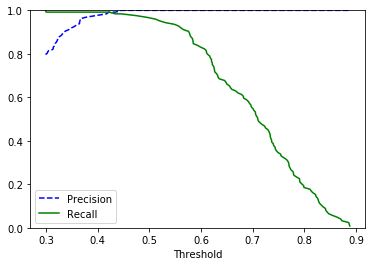

In [60]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.show()

In [123]:
probab_threshold = 0.3 # setting threshold at 0.25
pred_labels = np.where(pred_labels > probab_threshold, 1, 0)

In [124]:
get_scores(labels, pred_labels)

precision   : 0.45
recall      : 1.0
fbeta score : 0.8


### Evaluate on test set

In [125]:
cardio_test = strat_test_set.copy()
test_labels = cardio_test['chd']
cardio_test.drop('chd', axis = 1, inplace = True)

In [126]:
cardio_test_prepared = pd.DataFrame(data_prep_pipeline.fit_transform(cardio_test))

In [127]:
pred_test_labels = best_clf.predict_proba(cardio_test_prepared)[:, 1] 
pred_test_labels = np.where(pred_test_labels > probab_threshold, 1, 0)

In [128]:
get_scores(test_labels, pred_test_labels)

precision   : 0.54
recall      : 0.75
fbeta score : 0.7


In [71]:
always_1_labels = np.ones(len(test_labels))
get_scores(test_labels, always_1_labels)

precision   : 0.3870967741935484
recall      : 1.0
fbeta score : 0.759493670886076


In [129]:
import pickle 
with open('final_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

In [130]:
with open('data_prep_pipeline.pkl', 'wb') as file:
    pickle.dump(data_prep_pipeline, file)

In [131]:
with open('probab_threshold.pkl', 'wb') as file:
    pickle.dump(probab_threshold, file)